# VESPA Tutorial
This tutorial walks through some common use cases of exoplanet validation code VESPA, both via command line and the Jupyter interface. 


The code is intended to be run via command line, so this notebook shows how to create the files needed to run VESPA via command line for various cases. 

You do not need this notebook to run VESPA (and later in the notebook, you will see how to use Jupyter lab to run terminal commands). What you DO need to run VESPA is the following files:
-  **transit.txt**: A text file containing the transit photometry in three columns: time from midtransit (days), flux (relative), flux error (fractional). 
- **star.ini**: A file containing the observed, available properties of the target star (you can include effective temperature, metallicity, log(g), magnitudes)
- **fpp.ini**: An initial condition file containing the system properties (RA, DEC, plantary period, $R_{p}/R_{*}$, and reduction parameters (aperture, maxiumum depth of secondary eclipse)

First, let's go through what each of these files look like. A simple use case is attached. Go look at the file formats in folder TestCase1; these are the formats VESPA requires. 

### Exercise 1: Basic use case
##### Run VESPA using sample files from command line
This code can be run via command line. 
There are two ways to do this:

Way 1: 

a) In JupyterLab, open up a command line window (File- > New Launcher -> Terminal) and change to the directory containing these sample files:

> `> cd TestCase1`

b) Compute the star model using the isochrones package. This requires the star.ini file, which contains the measured stellar parameters on which the stellar model will be based. 

> `> starfit`

c) Run the calcfpp command inside the directory (here, we limit the steps computed to 100 by including option `-n 100`; if you are running real calculations and have the time to wait for them to finish, remove this or up the step count):

> `> calcfpp -n 100`

Way 2:

a) In the parent directory (in this case, your local directory, which contains folder TestCase1), compute the star model:

>`> starfit TestCase1`

b)   and run the calcfpp command:

>`> calcfpp TestCase1 -n 100`

This command takes as its argument the directory containing the three files described above. 

Once you've run this: some plots are generated automatically. Try glancing through those plots before we delve more deeply into exactly what VESPA was doing at each stage listed above. 

In [4]:
%pylab inline
import sys
import os
import vespa
import pandas as pd
import numpy as np
import h5py
import corner
from vespa.populations import DEFAULT_MODELS

Populating the interactive namespace from numpy and matplotlib


In [5]:
# only run this on local system - delete this cell later

sys.path.append('/Users/jcbecker/Documents/GitHub/isochrones_vespa')

In [6]:
vespa_tutorial_directory = '/Users/jcbecker/Documents/GitHub/vespa-tutorial/Notebooks/'
# change this 

### Exercise 2: Walking through VESPA
#### You won't need to do any of this yourself when running VESPA - starfit will do it all for you (and error checking, logging, etc). This notebook is for learning purposes. Use the real script (not this notebook) for real science!
To calculate a final false positive probability for an exoplanet, VESPA first makes models of the star using stellar parameters that the user provides. This was done in the first exercise in a single line, but you're probably wondering: what exactly is being done when these models are generated? 

The `starfit` script actually calls a method in package `isochrones`.

First, let's look at what our signal for this system looks like:

In [7]:
folder = "~/Documents/GitHub/vespa-tutorial/Notebooks/TestCase2/"
file = "foldedlc.csv"
light_curve = pd.read_csv(folder + file, names =['time', 'flux','err'], delim_whitespace=True)

Text(0,0.5,'Flux')

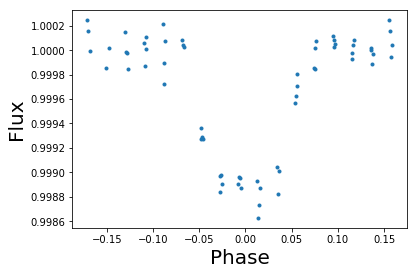

In [8]:
plot(light_curve['time'],light_curve['flux'],'.')
xlabel("Phase", fontsize=20)
ylabel("Flux", fontsize=20)
# You'll notice this light curve has already been reduced, detrended, and fit. 
# What we have now is what we need for VESPA, a phase-folded lightcurve.

[TODO: Maybe we can fit the transit? That might just be distracting...]

The next question, of course, is this: although this signal looks like a planet, it may not actually be one. 

What are some possible signals or geometries that could masquerade as a planet?

In [9]:
## Brainstorm your ideas here:
#
#
#
#

Given all the possible false positive signals that you have listed above, you can probably see why it's important to check that the planet signal is actually a planet. 

The basic way to do this is to compute models for each possible false positive signal, and compare those models to the "true planet" model. By determining the posterior probability of each of the false positive scenarios and of the true scenario, you can determin the final false positive probability for this so-called "planet".

In [100]:
from isochrones.starmodel import StarModel # This is an object used the model the star. 
from isochrones.isochrone import get_ichrone # This returns a particular isochrone from the Dartmouth models.
ini_file = 'star.ini' # Path to 'star.ini' file for star you need models for. 

models = 'mist'
bands = ''
Mod = StarModel
folder = vespa_tutorial_directory + 'TestCase3/'
model_filename = ''
mult = 1
            

In [101]:
# If you want to generate these files yourself..

# Or to save time, we can load already completed runs. Let's do that:
# let's use Andy's example.
# https://www.cfa.harvard.edu/~amayo/Astro99/code/mcmc_runs/converged/2017-06-20T01:27:42_ep201352100_10th_18wlkrs_2000000stps/2017-06-20T01:27:42_ep201352100b/


# First, let's look at the TRILEGAL field star simulation
#starfield = h5py.File("starfield.h5")
   
# When you do the false positive calculation, you need this because 

#### First: what does the local area around the target look like?

The starfit method generates all these files automatically. Each file contains the model for a possible scenario: for example, the star may be a single star or a binary, so models are generated for both scenarios. Let's take a look at some of the models generated. 

First, let's look at the file starfield.h5, which simulates the stellar photometry of the field.

In [102]:
import pandas as pd
starfield = pd.read_hdf(folder + "starfield.h5",'df')
# let's look at the columns in this posterior:
starfield.columns # These are the quantities simulated in the field.

Index([u'Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'Kepler_mag', u'g_mag', u'r_mag',
       u'i_mag', u'z_mag', u'DDO51_finf_mag', u'J_mag', u'H_mag', u'Ks_mag',
       u'Mact'],
      dtype='object')

Text(0,0.5,'Log(L / L$_{sun}$)')

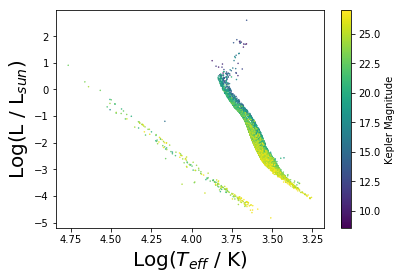

In [103]:
#Look at what's in the field:

scatter(starfield['logTe'], starfield[u'logL'],marker='.',
     c = starfield[u'Kepler_mag'],s=1)
gca().invert_xaxis()
colorbar(label="Kepler Magnitude")
xlabel("Log($T_{eff}$ / K)", fontsize=20)
ylabel("Log(L / L$_{sun}$)", fontsize=20)

# So, what we see here is the HR diagram for the simulated star field. 

# more details on how simulation is run:
#  http://stev.oapd.inaf.it/~webmaster/trilegal_1.6/help.html

[TODO: Describe how the starfield is used - maybe make RA/DEC plot, however Tim does that in the code?]

#### Next: let's look at models for the planet-host itself.

Part of the uncertainty in our understanding of planets comes from our uncertainty of the star itself. There are entire conferences named after this concept ( https://www.ipac.caltech.edu/event/know-thy-star-2017 )!

Beyond the exact radius of the star (which affects the radii we measure for the planets), one of the things we don't know for sure about a Kepler planet host is whether it is a single star, a binary, or even a hierarchical triple system. 

The values that we input into the `star.ini` file were from observations. Recall, the `star.ini` file for this particular run looked something like this:

In [104]:
star_ini_data = open(folder + "star.ini" ,'r')
star_ini_content = star_ini_data.readlines()
star_ini_data.close() 
%page star_ini_content

['J = 11.104, 0.030\n',
 'H = 10.686, 0.030\n',
 'K = 10.648, 0.029\n',
 'Kepler = 12.410\n',
 '\n',
 'Teff = 5257.0, 50.0\n',
 'feh = 0.03, 0.08\n',
 'logg = 4.49, 0.1\n']

Our goal is to fit the stellar models.
This file was the knowledge that we have about the star. You'll notice that there are also error bars on ``Teff, feh, and logg``. Actually, all spectroscopic parameters (``Teff, feh, logg``) are optional. Since we've included them, they will also be included in the fit. 

Let's say that we know for sure that our host star is a single star with no stellar companions. In that case, we can run a `starfit` Markov Chain Monte Carlo, which generates a posterior of all stellar parameters which could recreate the properties we put into our `star.ini` file. 

Let's visualize the results of that `starfit`:

In [105]:
# We can either run this fresh, or just use the pre-generated files.
# If we were to run the model, you could use the following commands:
# mult = 1 #we are assuming there is only one star
# bands = StarModel.get_bands(ini_file)
# ichrone = get_ichrone(models, bands)

# mod = Mod.from_ini(ichrone, folder, use_emcee=True, N=mult,
#                                ini_file=ini_file, name=model_filename)
# mod.fit(verbose=True, overwrite=True)
# mod.save_hdf('temp2')

# However, the fitting can take a while, so let's just load the pre-fit files. 
model_single = pd.read_hdf(folder + "dartmouth_starmodel_single.h5",'samples')

In [106]:
# Now, let's look at the results of the fit. The parameters that have been fit include:
model_single.columns


Index([u'B_mag', u'D51_mag', u'H_mag', u'I_mag', u'J_mag', u'K_mag',
       u'Kepler_mag', u'R_mag', u'Teff', u'U_mag', u'V_mag', u'W1_mag',
       u'W2_mag', u'W3_mag', u'age', u'g_mag', u'i_mag', u'logL', u'logg',
       u'mass', u'r_mag', u'radius', u'z_mag', u'feh', u'distance', u'AV',
       u'lnprob'],
      dtype='object')

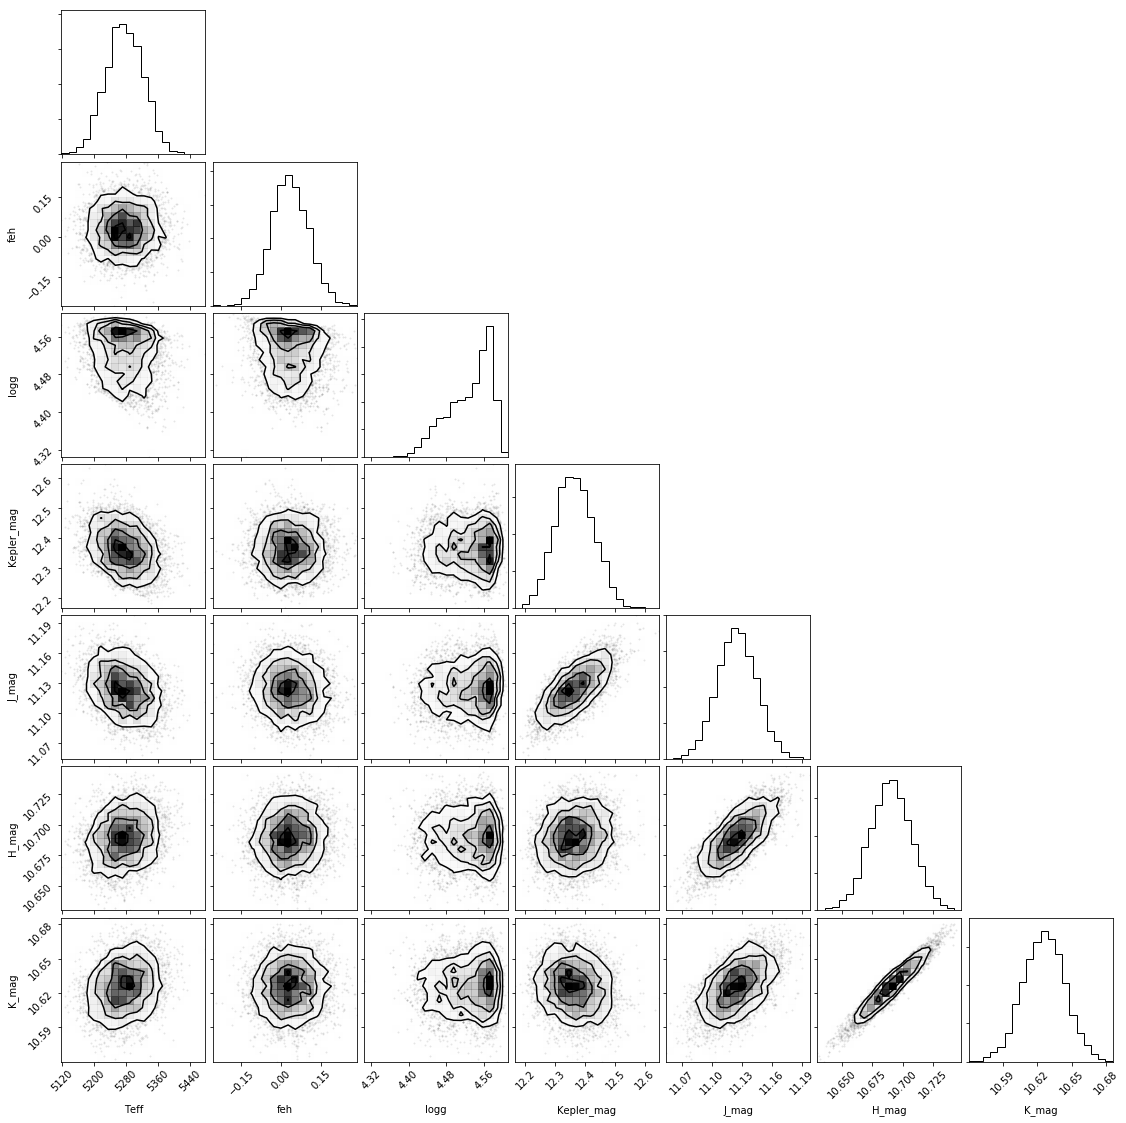

In [107]:
# So let's make a triangle plot to better visualize what's going on. 
# Let's make a triangle plot with only a subset of parameters. So, there will be some dependancies
# that you won't be able to see. You can try plotting other parameters, too, but let's try the ones 
# we put in the star.ini file to star with. 
params = ['Teff', 'feh', 'logg', 'Kepler_mag',u'J_mag', u'H_mag',u'K_mag'] 
single_fig = corner.corner(model_single[params], labels=params)


What you should notice above is that the values and errors we put into the `star.ini` file are not exactly what we're getting out of the priors. Why could that be? 

The answer is that the `starfit` module also imposes priors on the fit. [TODO: add more detail about this, ask Tim what to include]

Next: what about the physical properties of the star, such as the radius and mass? Those parameters will affect our false positive calculation. Let's take a look at the posteriors for those:

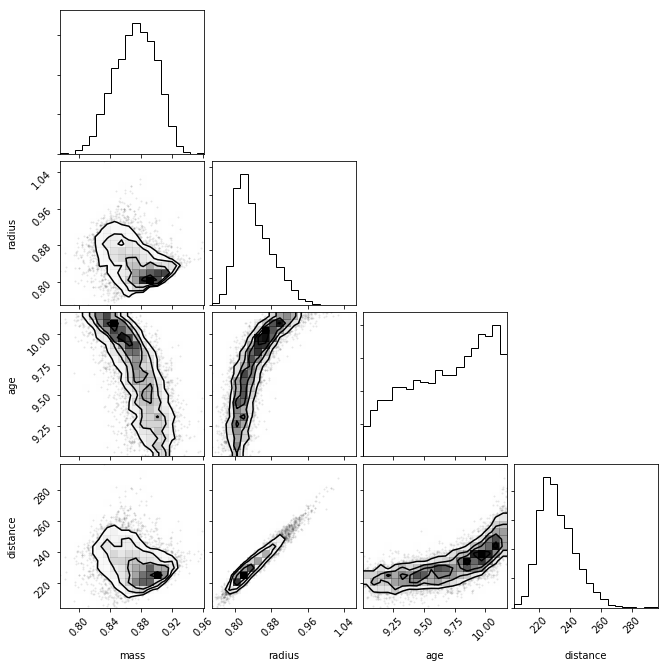

In [108]:
params = ['mass', 'radius', 'age', 'distance',] 
single_fig = corner.corner(model_single[params], labels=params)

# What if the 'planet host' is a stellar binary?
So, what we've just looked at is the results of the `starfit` method for a single star. The quantities that we put in to the `star.ini` file were visual magnitudes, the apparent effective temperature, the metallicity, and the gravity. However, all of those quantities come from observations, which cannot discriminate between (for example) a single star and a binary that just appears to have those properties. So, what if we tried to re-do the previous fit, but this time try to find a binary that mimics the quantites in `star.ini`?

In [109]:
model_double = pd.read_hdf(folder + "dartmouth_starmodel_binary.h5",'samples')
model_double.columns

Index([u'B_mag', u'D51_mag', u'H_mag', u'I_mag', u'J_mag', u'K_mag',
       u'Kepler_mag', u'R_mag', u'Teff', u'U_mag', u'V_mag', u'W1_mag',
       u'W2_mag', u'W3_mag', u'age', u'g_mag', u'i_mag', u'logL', u'logg',
       u'r_mag', u'radius', u'z_mag', u'B_mag_A', u'B_mag_B', u'D51_mag_A',
       u'D51_mag_B', u'H_mag_A', u'H_mag_B', u'I_mag_A', u'I_mag_B',
       u'J_mag_A', u'J_mag_B', u'K_mag_A', u'K_mag_B', u'Kepler_mag_A',
       u'Kepler_mag_B', u'R_mag_A', u'R_mag_B', u'U_mag_A', u'U_mag_B',
       u'V_mag_A', u'V_mag_B', u'W1_mag_A', u'W1_mag_B', u'W2_mag_A',
       u'W2_mag_B', u'W3_mag_A', u'W3_mag_B', u'g_mag_A', u'g_mag_B',
       u'i_mag_A', u'i_mag_B', u'r_mag_A', u'r_mag_B', u'z_mag_A', u'z_mag_B',
       u'mass_A', u'mass_B', u'radius_B', u'Teff_B', u'logg_B', u'logL_B',
       u'feh', u'distance', u'AV', u'lnprob'],
      dtype='object')

What you'll notice this time is that the `starfit` method fit for the parameters of two stars, and there is a lot more degeneracy in the posteriors.

Again, try plotting different columns to see what the posteriors for different parameters look like if you assume the system is a binary. 

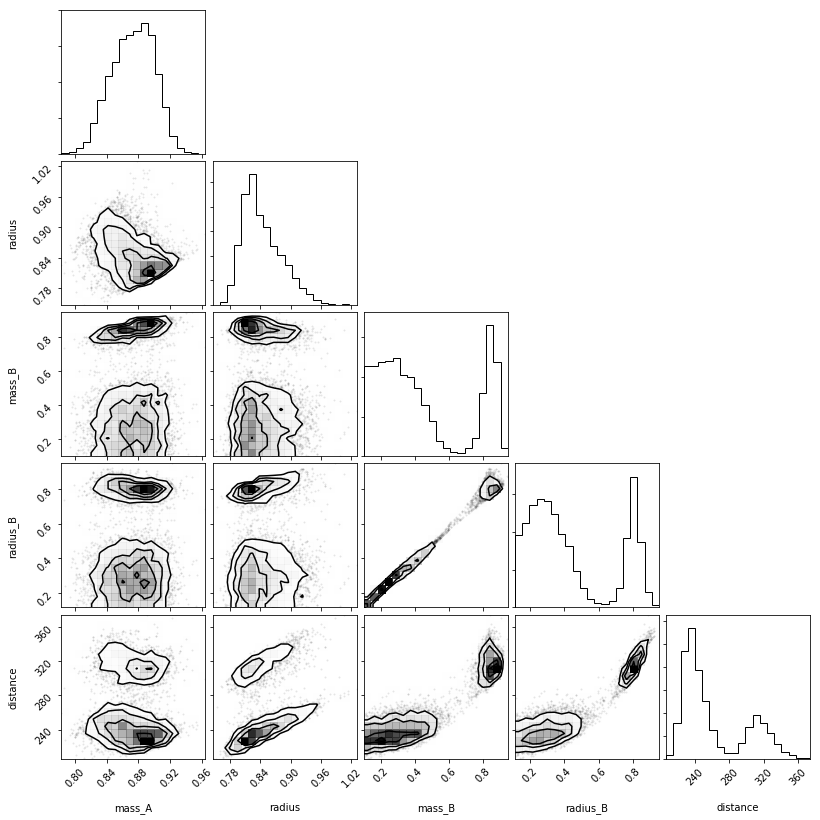

In [110]:
params = ['mass_A', 'radius', 'mass_B', 'radius_B', 'distance',] 
double_fig = corner.corner(model_double[params], labels=params)

In [111]:
model_triple = pd.read_hdf(folder + "dartmouth_starmodel_triple.h5",'samples')
model_triple.columns

Index([u'B_mag', u'D51_mag', u'H_mag', u'I_mag', u'J_mag', u'K_mag',
       u'Kepler_mag', u'R_mag', u'Teff', u'U_mag', u'V_mag', u'W1_mag',
       u'W2_mag', u'W3_mag', u'age', u'g_mag', u'i_mag', u'logL', u'logg',
       u'r_mag', u'radius', u'z_mag', u'B_mag_A', u'B_mag_B', u'B_mag_C',
       u'D51_mag_A', u'D51_mag_B', u'D51_mag_C', u'H_mag_A', u'H_mag_B',
       u'H_mag_C', u'I_mag_A', u'I_mag_B', u'I_mag_C', u'J_mag_A', u'J_mag_B',
       u'J_mag_C', u'K_mag_A', u'K_mag_B', u'K_mag_C', u'Kepler_mag_A',
       u'Kepler_mag_B', u'Kepler_mag_C', u'R_mag_A', u'R_mag_B', u'R_mag_C',
       u'U_mag_A', u'U_mag_B', u'U_mag_C', u'V_mag_A', u'V_mag_B', u'V_mag_C',
       u'W1_mag_A', u'W1_mag_B', u'W1_mag_C', u'W2_mag_A', u'W2_mag_B',
       u'W2_mag_C', u'W3_mag_A', u'W3_mag_B', u'W3_mag_C', u'g_mag_A',
       u'g_mag_B', u'g_mag_C', u'i_mag_A', u'i_mag_B', u'i_mag_C', u'r_mag_A',
       u'r_mag_B', u'r_mag_C', u'z_mag_A', u'z_mag_B', u'z_mag_C', u'mass_A',
       u'mass_B', u'mass_C', u

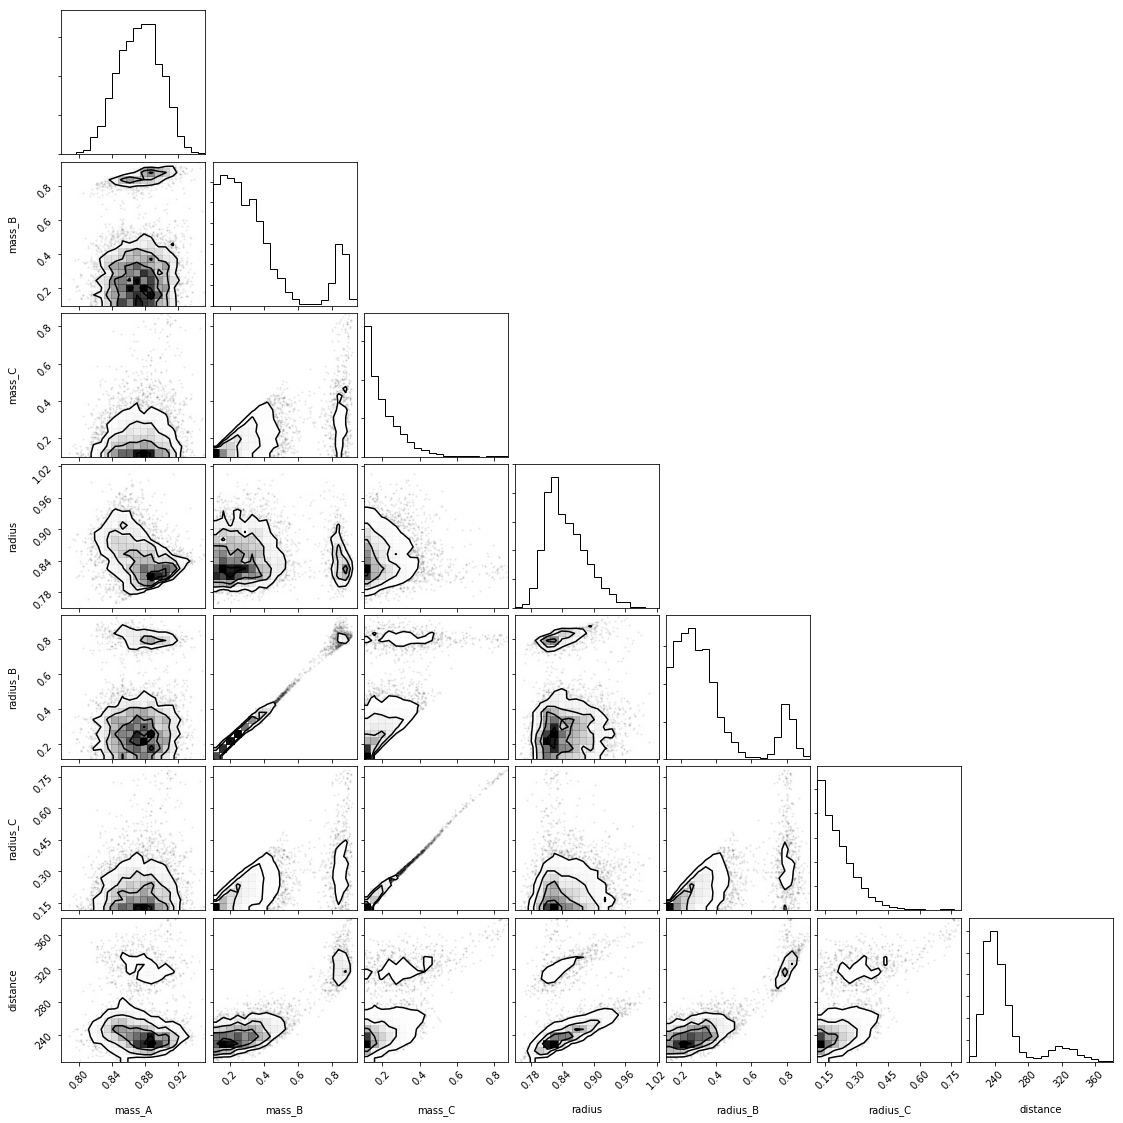

In [112]:
params = ['mass_A', 'mass_B', 'mass_C','radius', 'radius_B','radius_C', 'distance',] 
triple_fig = corner.corner(model_triple[params], labels=params)

Again - wide posteriors and lots of degeneracy! All these solutions could be possible sets of stars that would create the observations that we put into the `star.ini` file. 

#### Summary thus far:
First, we looked at the local star field (simulation) near the 'planet hosting' star.

Then, we examined the results of three MCMC fits to the parameters that we put into `star.ini`: one fit for a single star solution, one fit for a stellar binary, and another for a triple system. 

Together, these fits help form a population of reasons we might have a false positive. So, the next step is to take the simulation and the fits and from them, derive false positive probabilities for our signal. 
To do this, VESPA creates a 'population set' of all models that are being considered as an explanation for the signal. We define these by using the files that we just walked through, which are used to define the probabilities for a variety of scenarios. 



In [114]:
from isochrones import StarModel, BinaryStarModel, TripleStarModel

#planet parameters: you need to input these in fpp.ini


# Define files to use - we just walked through these.
#single_starmodel_file = folder + "dartmouth_starmodel_single.h5"
#binary_starmodel_file = folder + "dartmouth_starmodel_binary.h5"
#triple_starmodel_file = folder + "dartmouth_starmodel_triple.h5"
#single_starmodel = StarModel.load_hdf(single_starmodel_file)
#binary_starmodel = BinaryStarModel.load_hdf(binary_starmodel_file)
#triple_starmodel = TripleStarModel.load_hdf(triple_starmodel_file)
#starfield_file = folder + "starfield.h5"
#popset_file = "pop_temp_file"

# Generate the population set file
#popset = vespa.PopulationSet(period=period, mags=single_starmodel.mags,
#                               ra=ra, dec=dec,
#                               trilegal_filename=starfield_file, # Maybe change parameter name?
#                               starmodel=single_starmodel,
#                               binary_starmodel=binary_starmodel,
#                               triple_starmodel=triple_starmodel,
#                               rprs=rprs,
#                               savefile=popset_file)

In [115]:
# Or, load a previously generated version. 
popset = vespa.PopulationSet.load_hdf("popset.h5")

In [116]:
popset.modelnames # Ask Tim - why is it empty?

[]

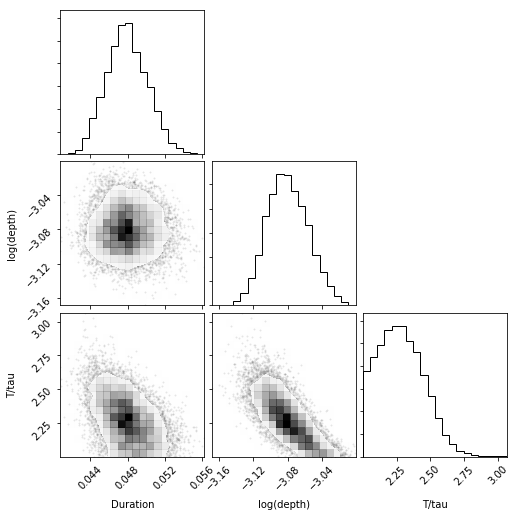

In [117]:
import pandas as pd
data = pd.read_pickle(folder + "trsig.pkl")
transit_post = data.corner()

When running the false positive calculation, you need to consider all models that are being considered as explanations for the signal. 

In [123]:
print DEFAULT_MODELS
print popset.modelnames
tmp = vespa.FPPCalculation(data, popset)
tmp.lhood(DEFAULT_MODELS[0])

['beb', 'heb', 'eb', 'beb_Px2', 'heb_Px2', 'eb_Px2', 'pl']
[]


ValueError: bebs not in modelnames: []

### Exercise N-1: Generate the files needed to run VESPA automatically
In the previous section, we 
